# Graph Based Segragation Index

Socio- Economic Data Retrived from:

http://www.ecuadorencifras.gob.ec/documentos/datos/Poblacion_y_Demografia/Censo_poblacion_y_vivienda_/bdd_nivel_manzana_censal/Spss/CPV2010M_SPSS_Azuay.zip

SPSS file processed in R. We use dwelling as our unit of analysis, all the data has been previously aggregated at this level

In [1]:
%load_ext autoreload
%autoreload 2
import multiplex_segregation as ms
from multiplex_segregation import np, pd, gpd, nx, ox
import glob
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import display, Markdown

## Configuration script

In [2]:
network_type = 'drive'                    #get walkable streets and paths (ignores directionality)
retain_all = False                       #retain all only largest connected component
crs_osm = {'init':'epsg:4326'}           #crs that osm uses
crs_utm = {'init':'epsg:32717'}          #crs that for the city of Cuenca in UTM
input_folder = 'input_data'              #the input urban areas shapefiles folder

urban_area = 'Sectores_EC.shp'
blocks = 'blocks.shp'                    #the input shapefile name for block geometry
busLine = 'bus_lines.shp'                #the input shapefile name for bus lines
busStop = 'bus_stops'                    #the input file for all bus stop shaspes
allFiles = glob.glob('{}/{}/*.shp'.format(input_folder, busStop)) #list of all bus stop shapes
tramLine = 'tram_lines.shp'              #the input shapefile name for tram lines
tramStop = 'tram_stops.shp'              #the input shapefile name for tram stops
icvIndex = 'blockICV.csv'    #the input csv for calculated ICV index

graphs_folder = 'output_data/graphs'     #output folder to save graphs
output_path = 'output_data'              #output folder to save the stats
output_img = 'output_data/img'           #output folder to save figures

### Read ShapeFiles and Reprojections

In [3]:
#import shapefile as geopandas dataframe
blocksGPD =  gpd.read_file('{}/{}'.format(input_folder, blocks))
busLineGPD = gpd.read_file('{}/{}'.format(input_folder, busLine))
tramLineGPD = gpd.read_file('{}/{}'.format(input_folder, tramLine))
tramStopGPD = gpd.read_file('{}/{}'.format(input_folder, tramStop))

busStop_list = []

for file_ in allFiles:
    lineNum = file_.split('linea_',1)[1].split('.')[0]
    df = gpd.read_file(file_)
    df['lineNum'] = int(lineNum)
    busStop_list.append(df)
busStopGPD = gpd.GeoDataFrame(pd.concat(busStop_list, ignore_index = True))

#import ICV index as pandas dataframe
icvIndexDf = pd.read_csv('{}/{}'.format(output_path, icvIndex), dtype = {
    'id_man': str,
    'Q1' : np.float64, 
    'Q2' : np.float64,
    'Q3' : np.float64,
    'Q4' : np.float64,
    'ICV': np.float64,
    'nDwelling' : np.int32, 
    'nPeople' : np.int32    
})

In [4]:
display(
    Markdown('**General Information**'),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: ' + str(len(blocksGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: ' + str(len(icvIndexDf))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: ' + str(len(busLineGPD.LINEA.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: ' + str(len(busStopGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: ' + str(len(tramLineGPD.FID_.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: ' + str(len(tramStopGPD.index)))
)

**General Information**

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: 3800

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: 3391

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: 29

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: 3037

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: 1

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: 41

## Download street network

Blocks define urban area, alpha shape is used to draw a boundary around multiple unconnected block geometries

Calculating Boundary with alpha = 0.004 ...


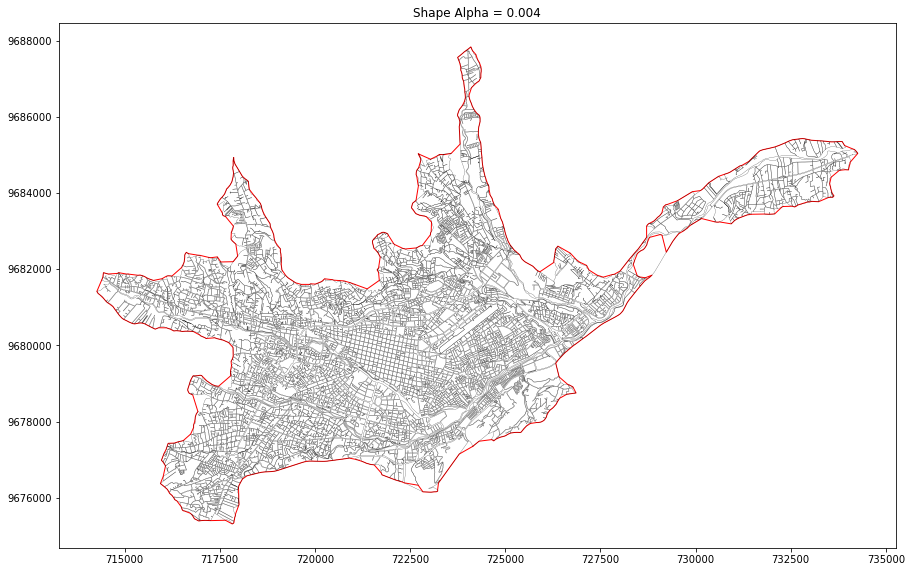

Calculating Boundary with alpha = 0.0035 ...


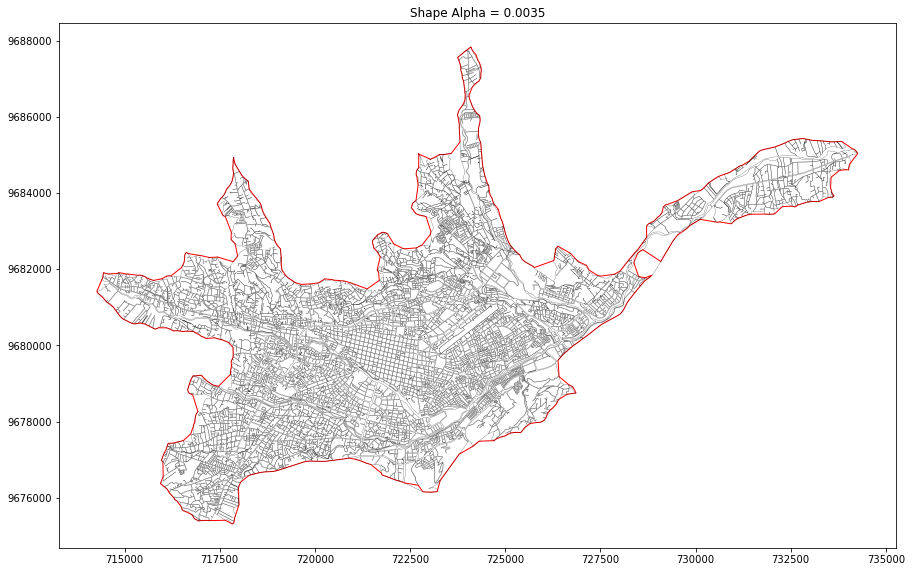

Calculating Boundary with alpha = 0.003 ...


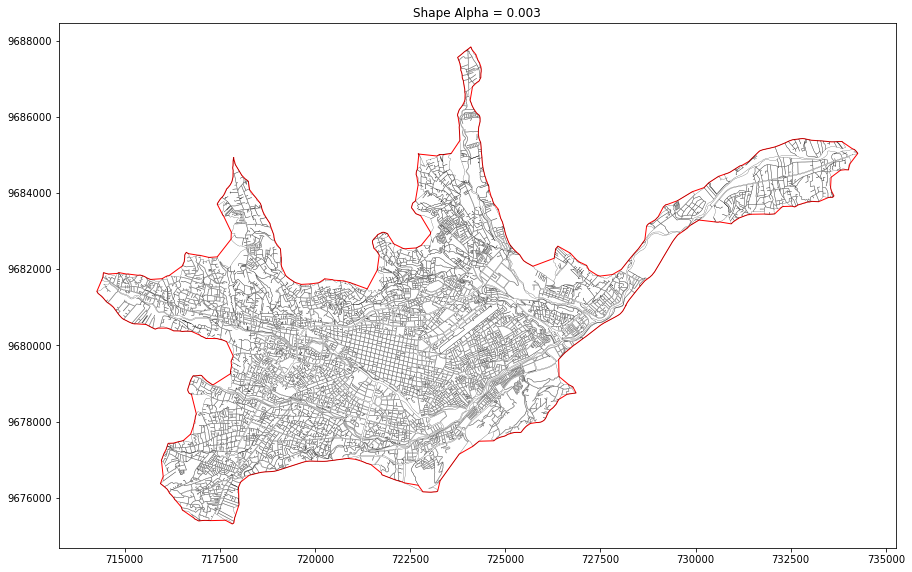

Calculating Boundary with alpha = 0.0025 ...


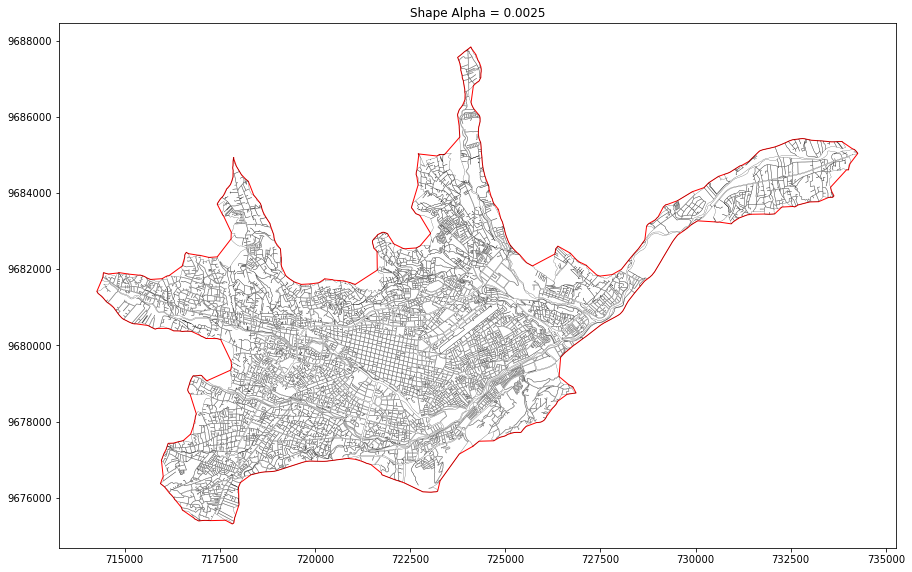

In [5]:
for i in range(4):
    alpha = 0.004 - (i*0.0005)
    temp = ms.boundary_from_areas(blocksGPD, alpha = alpha)
    base = temp.plot(color = 'white',edgecolor='red',linewidth=1, figsize = (15,10))
    base.set_title("Shape Alpha = {}".format(alpha))
    blocksGPD.plot(color = 'white',edgecolor='black',linewidth=0.2,  ax = base)
    plt.show()

## Create Street Network
create time weighted graph to represent the street network using Block Geometry, Alpha Value = 0.0025 and a walking speed = 5km/h

In [6]:
street_network, area = ms.construct_street_graph(blocksGPD,
                                                crs_osm, 
                                                crs_utm,
                                                alpha = 0.0025,
                                                buffer_dist=200,
                                                speed = 5
                                               )

Generating geometry...
Calculating Boundary with alpha = 0.0025 ...
Generating street graph...


C:\Anaconda\lib\site-packages\osmnx\utils.py:268: RuntimeWarning: invalid value encountered in arccos
  arc = np.arccos(cos)


Reprojecting street graph...
done!


In [7]:
#Save Road Network and Urban Area
print('Saving street graph and Urban Area')
ox.save_graph_shapefile(street_network, folder = graphs_folder, filename = '{}/shapefile'.format('street_network'))
ox.save_graphml(street_network, folder = graphs_folder, filename = '{}/graph'.format('street_network'))
area.to_file('{}/area'.format(output_path))

Saving street graph and Urban Area


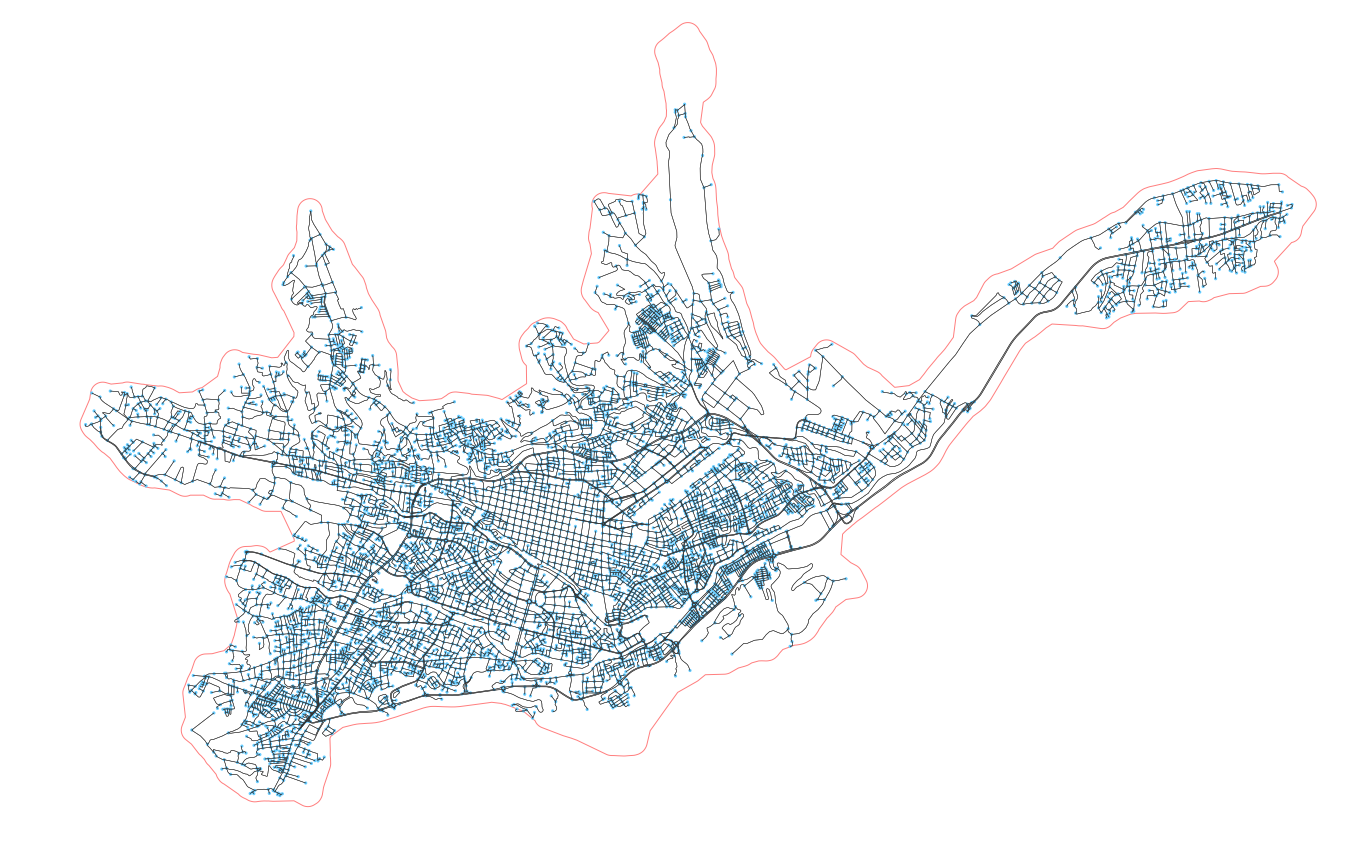

In [8]:
ms.plot_network(street_network, area)

## Get Road Network Stats

calculating shortest path betweenness...
calculating random walk betweenness...
calculating reaching centrality...
calculating information centrality...
generating plots...
calculating measures for: Betweenness Centrality


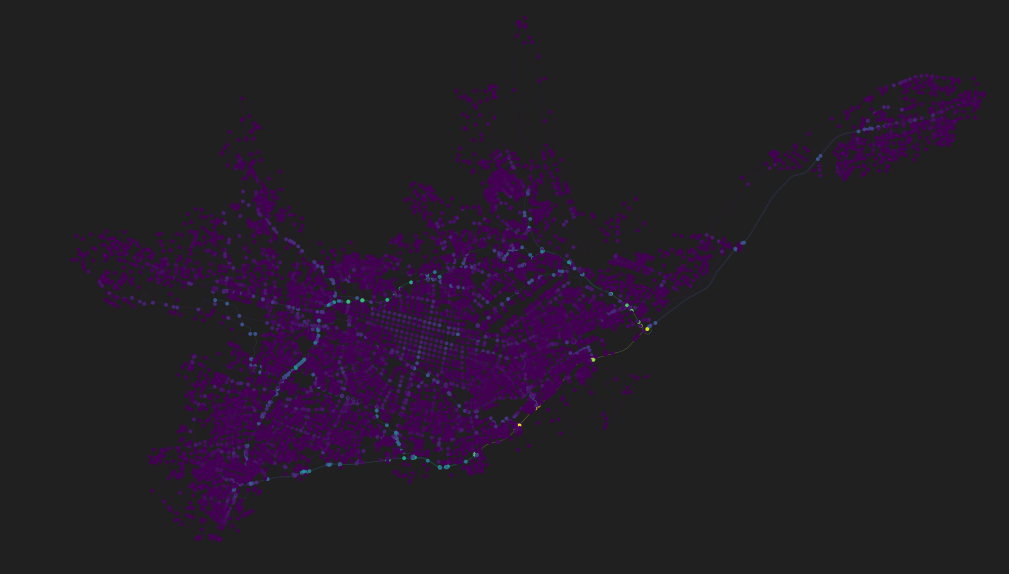

calculating measures for: Random Walk Betweenness


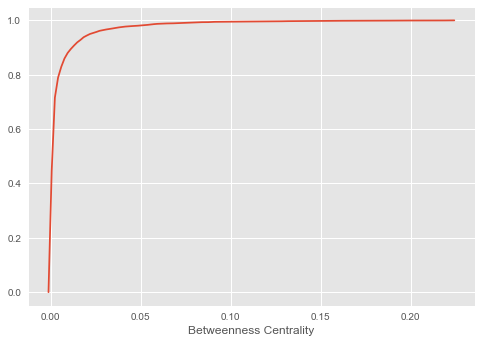

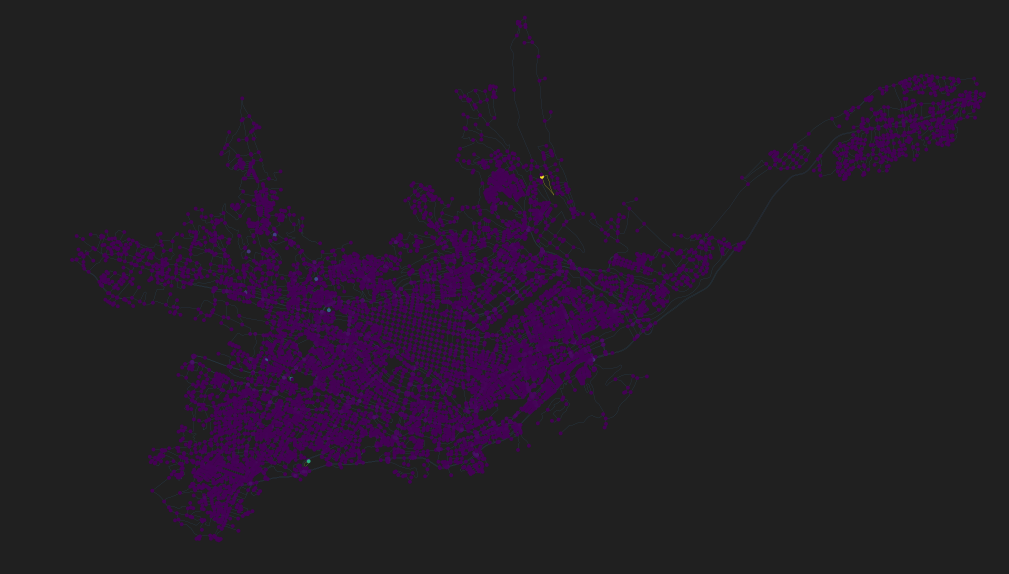

calculating measures for: Information Centrality


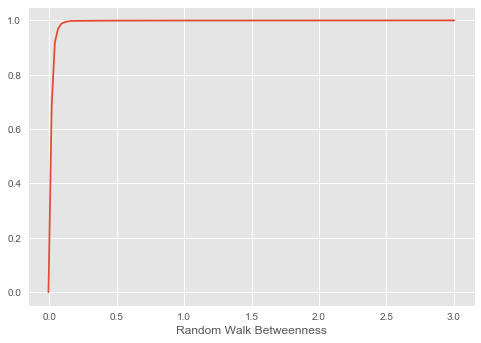

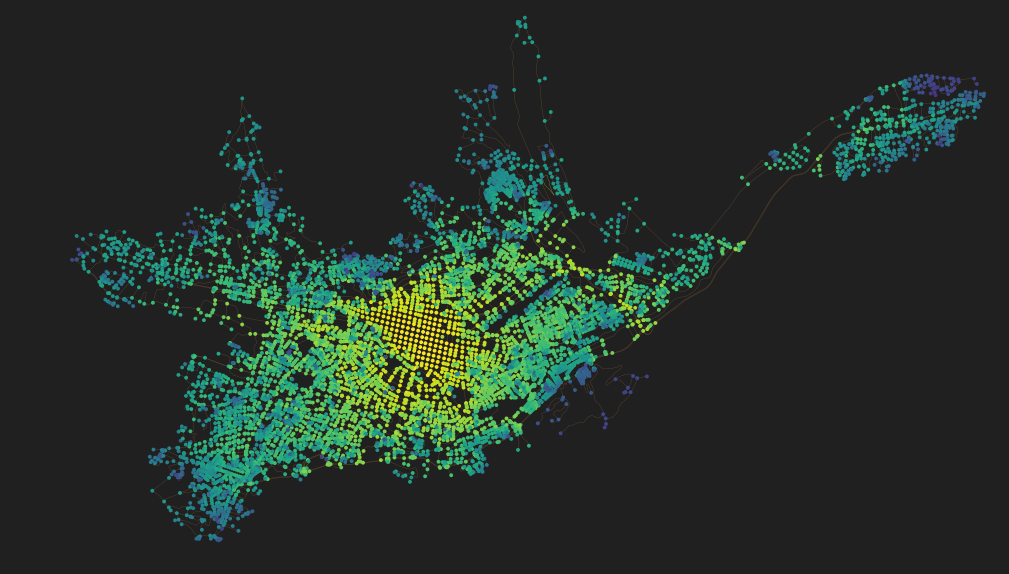

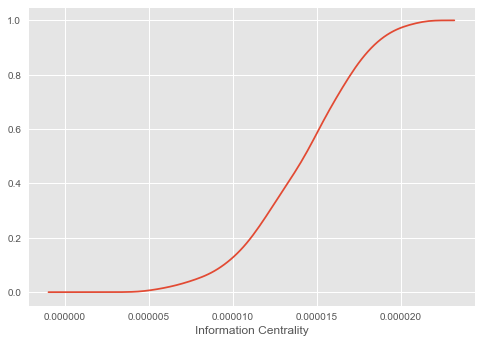

In [227]:
G = ms.network_stats(street_network, 1)
ox.save_graph_shapefile(G, folder = graphs_folder, filename = '{}/shapefile'.format('street_stats'))

## Create Bus Network Graph

plotting results for each line:


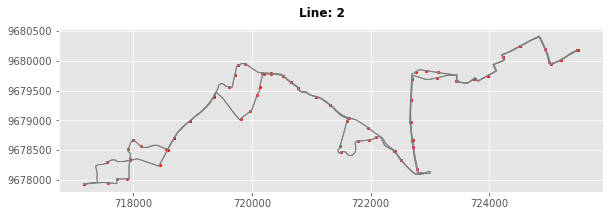

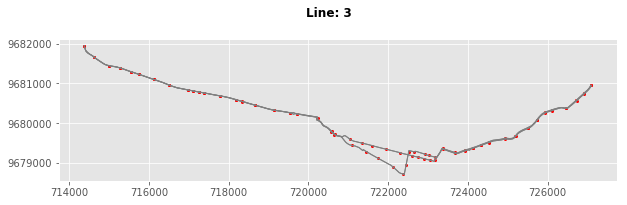

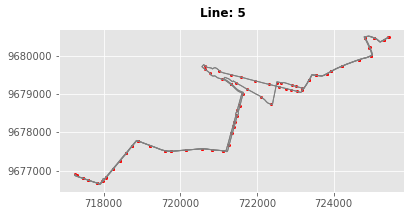

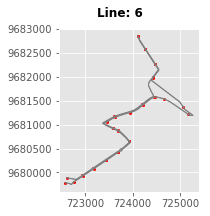

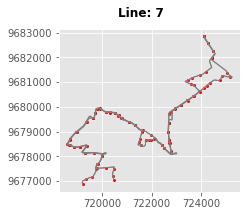

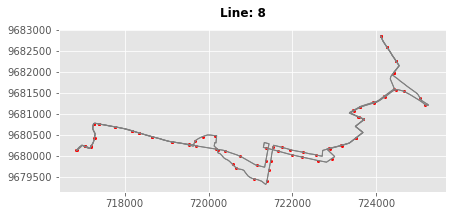

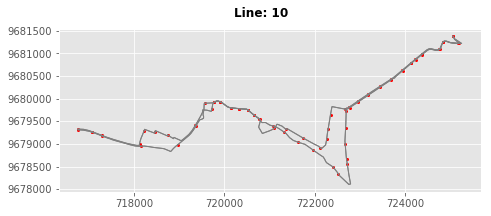

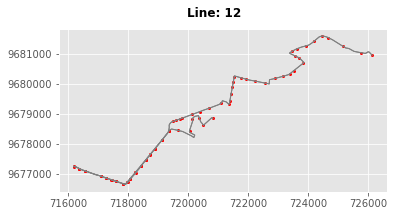

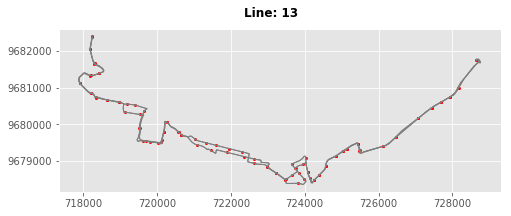

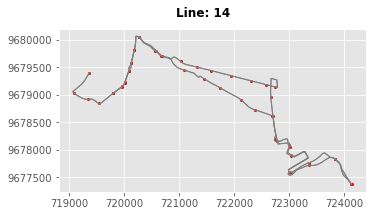

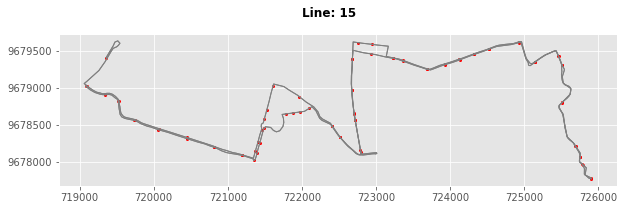

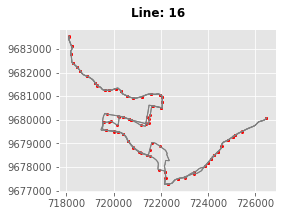

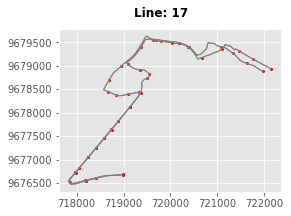

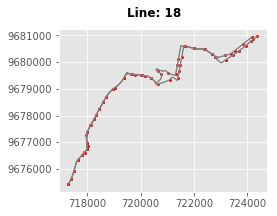

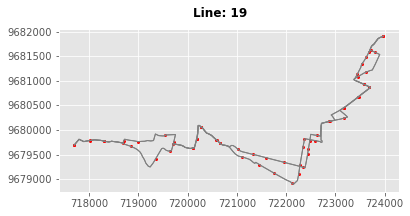

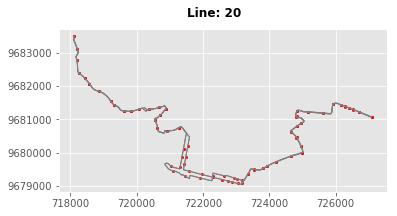

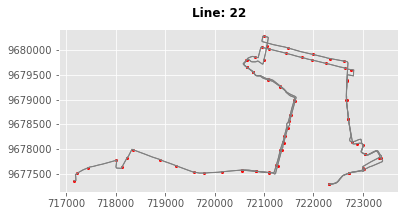

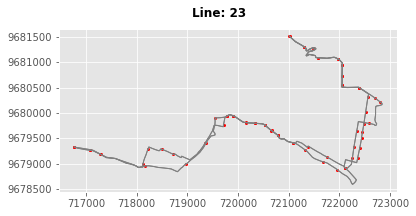

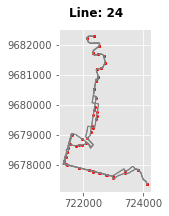

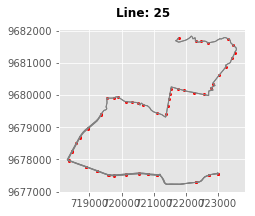

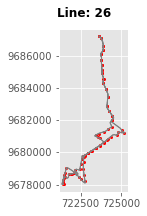

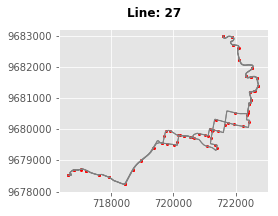

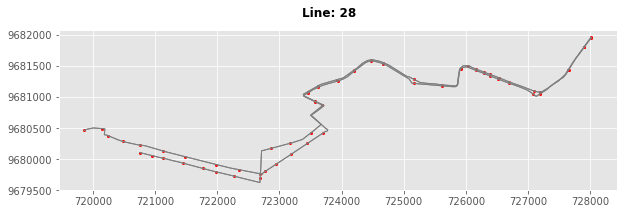

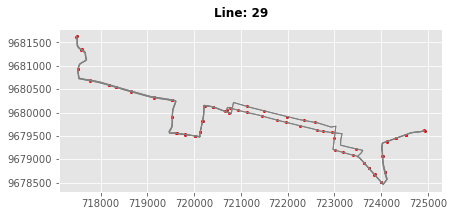

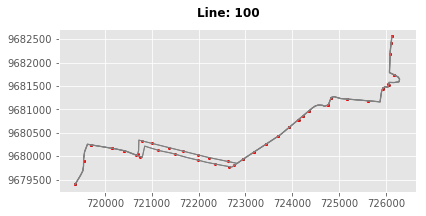

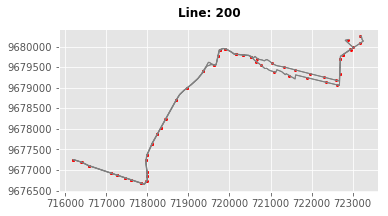

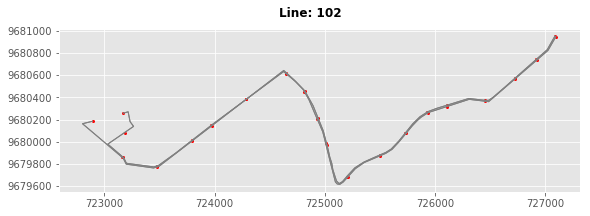

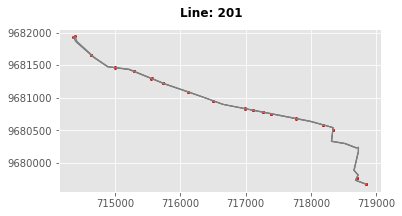

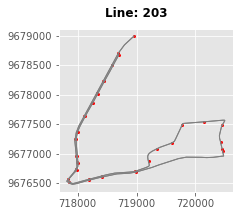

In [9]:
#create bus network
bus_network = ms.create_bus_network(busLineGPD, busStopGPD, area, speed = 30)
type(bus_network)
#plot bus network graph
ox.save_graph_shapefile(bus_network, folder = graphs_folder, filename = '{}/shapefile'.format('bus_network'))
ox.save_graphml(bus_network, folder = graphs_folder, filename = '{}/graph'.format('bus_network'))

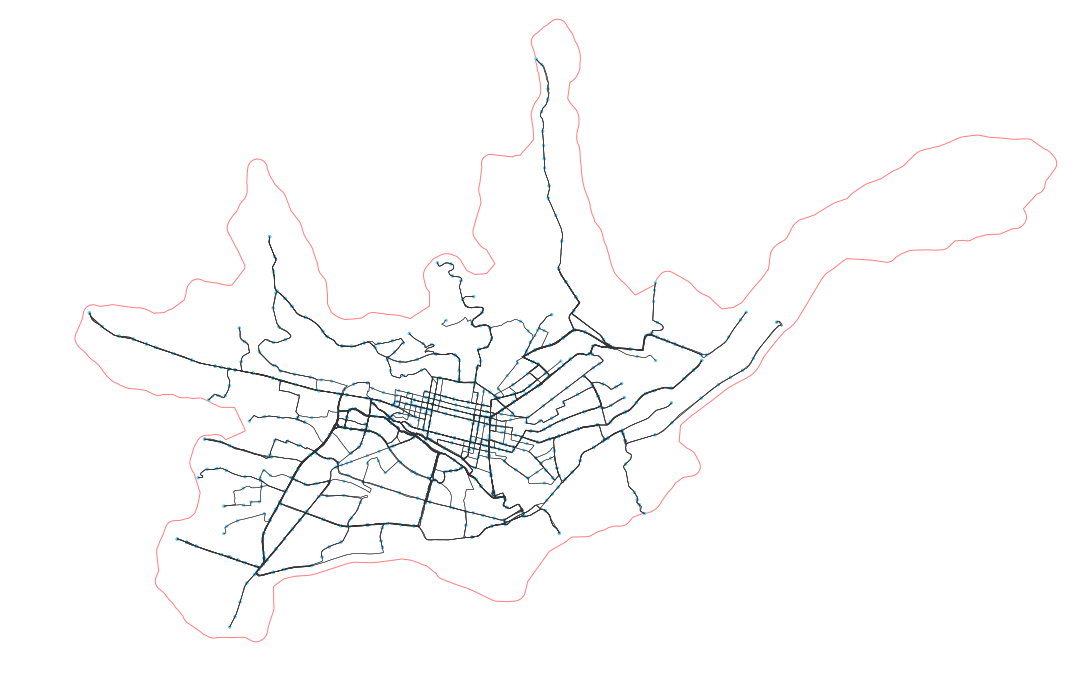

In [10]:
ms.plot_network(bus_network, area)

## Get Bus Network Stats

calculating shortest path betweenness...
calculating random walk betweenness...
calculating reaching centrality...
calculating information centrality...
generating plots...
calculating measures for: Betweenness Centrality


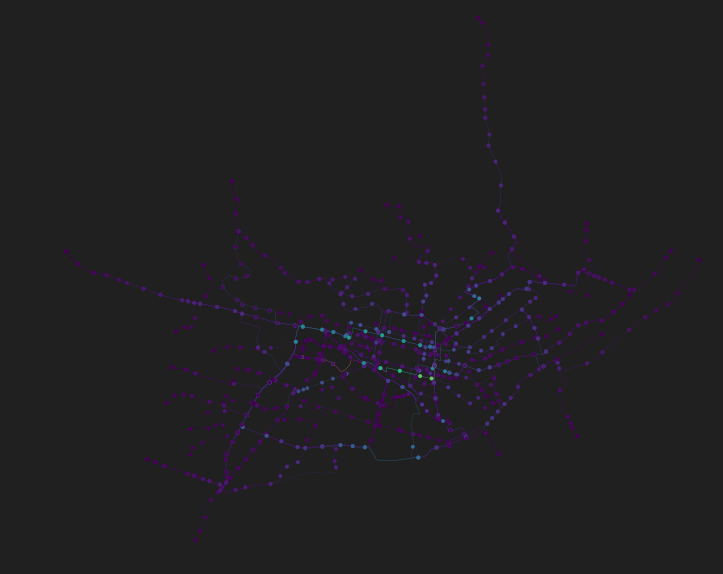

calculating measures for: Random Walk Betweenness


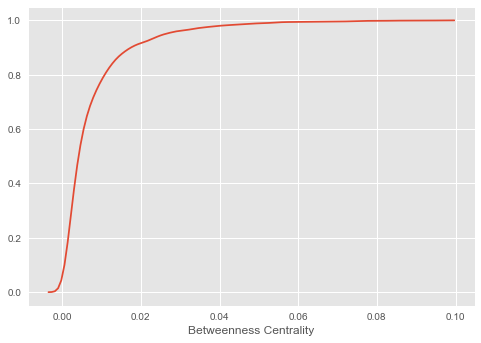

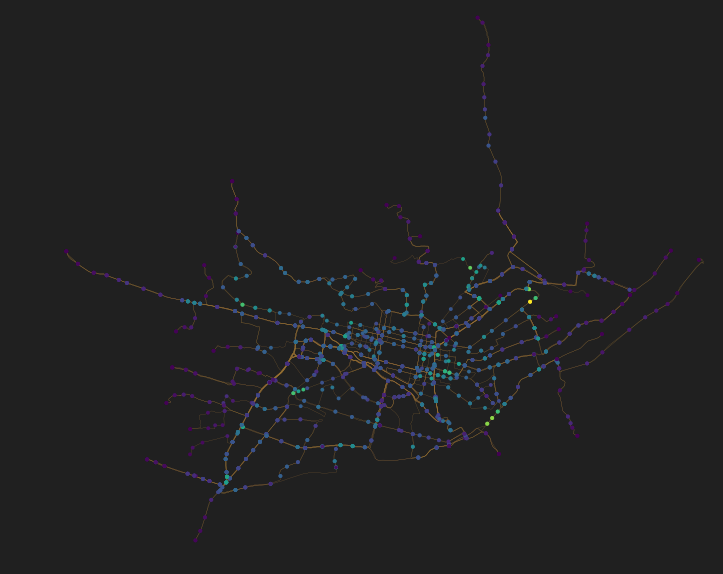

calculating measures for: Information Centrality


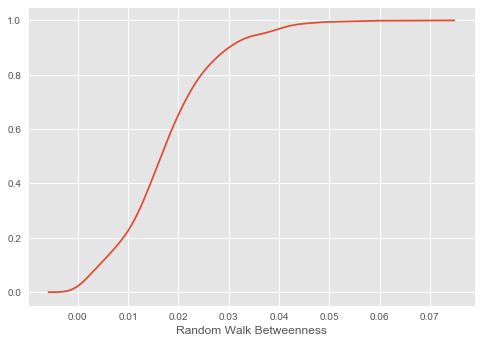

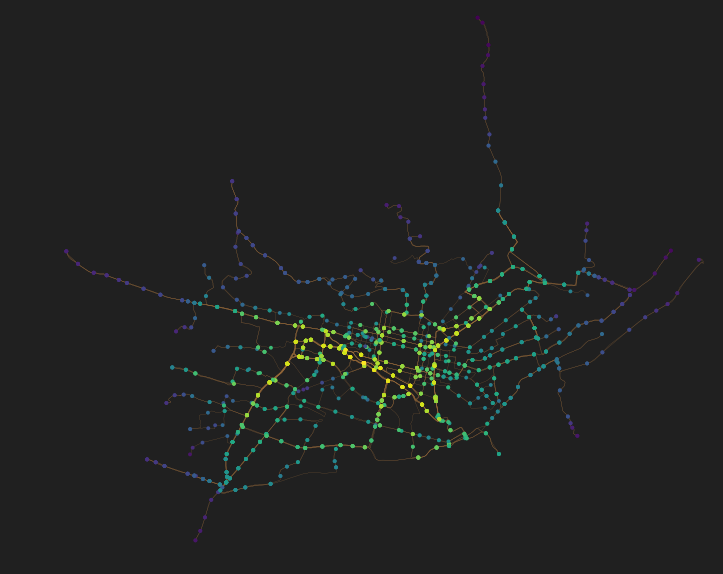

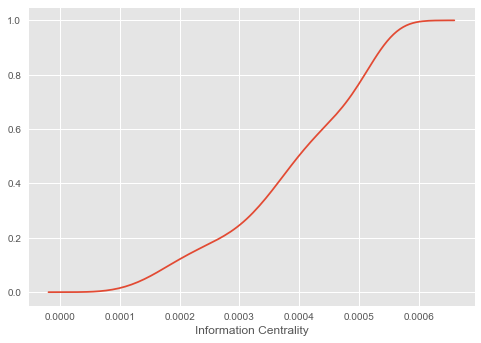

In [226]:
G = ms.network_stats(bus_network, 1)
ox.save_graph_shapefile(G, folder = graphs_folder, filename = '{}/shapefile'.format('bus_stats'))

## Create Tram Network Graph

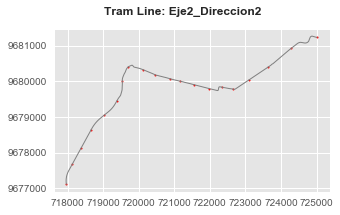

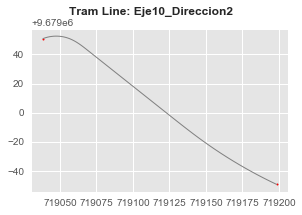

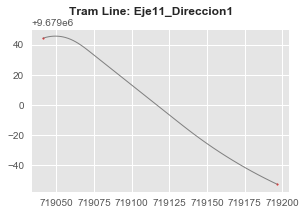

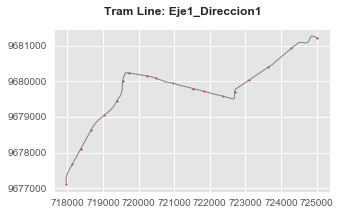

In [217]:
tram_network = ms.create_tram_network(tramLineGPD, tramStopGPD, area)
#plot bus network graph
ox.save_graph_shapefile(tram_network, folder = graphs_folder, filename = '{}/shapefile'.format('tram_network'))
ox.save_graphml(tram_network, folder = graphs_folder, filename = '{}/graph'.format('tram_network'))

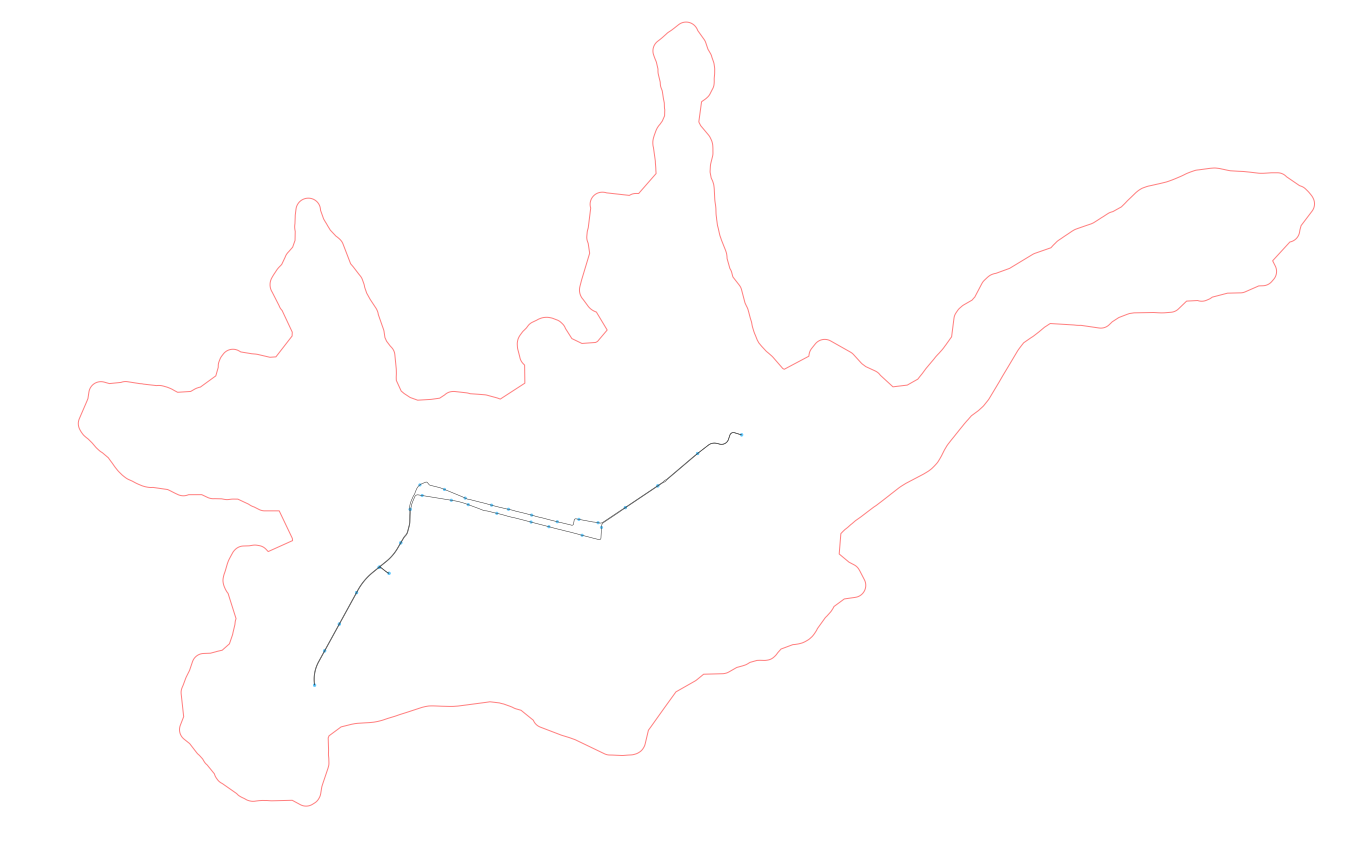

In [218]:
ms.plot_network(tram_network, area)

## Get Tram Network Stats

calculating shortest path betweenness...
calculating random walk betweenness...
calculating reaching centrality...
calculating information centrality...
generating plots...
calculating measures for: Betweenness Centrality


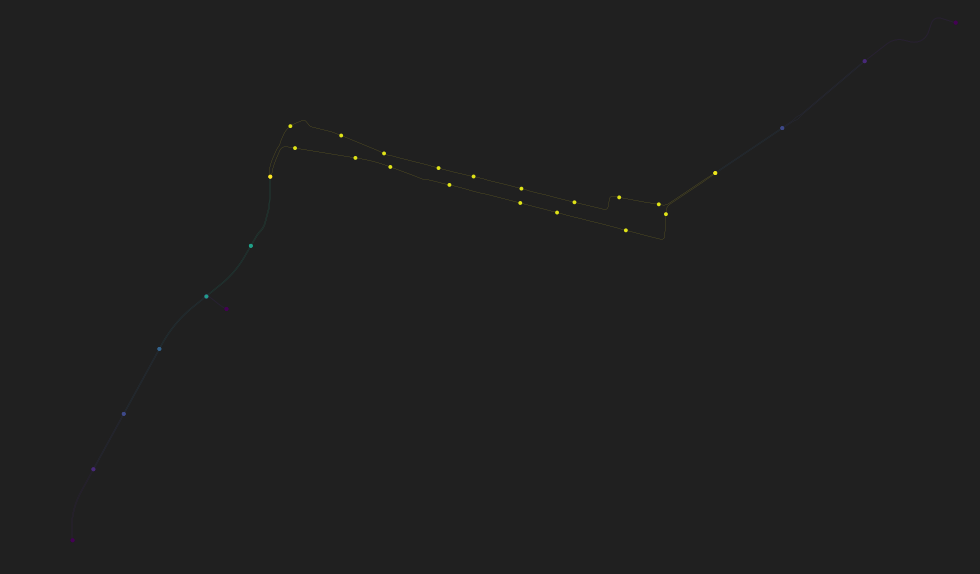

calculating measures for: Random Walk Betweenness


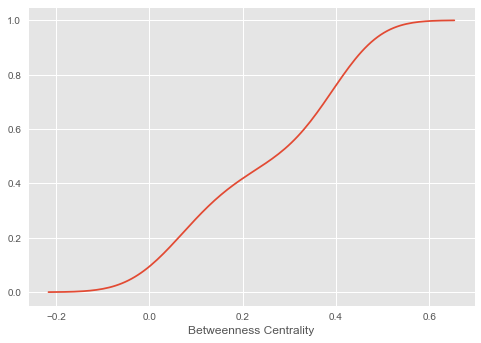

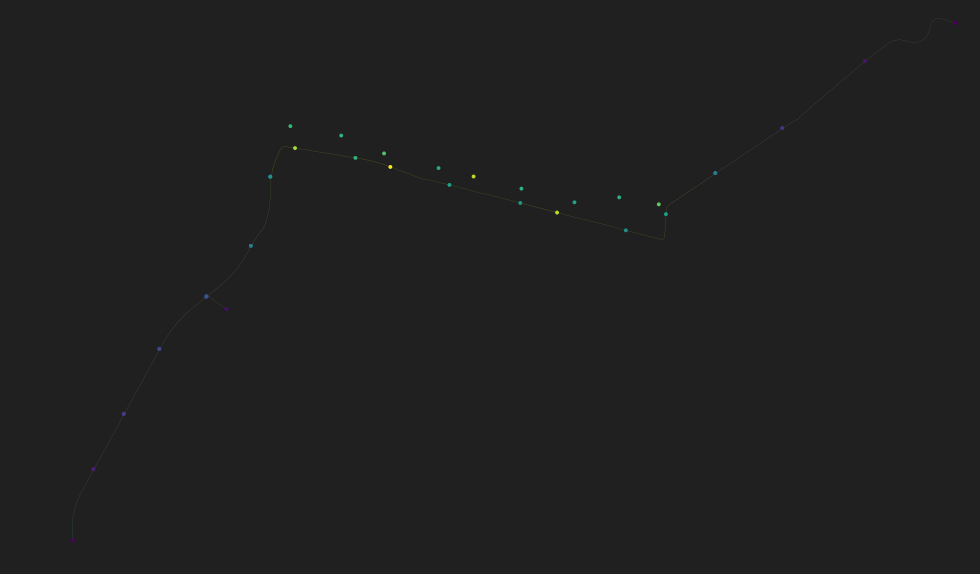

calculating measures for: Information Centrality


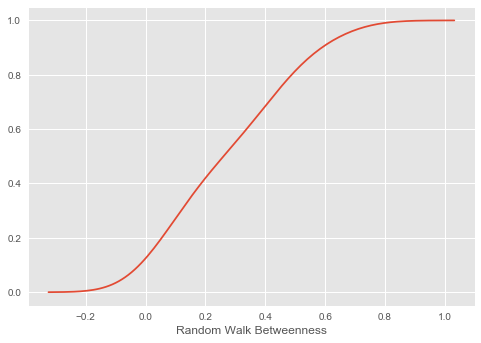

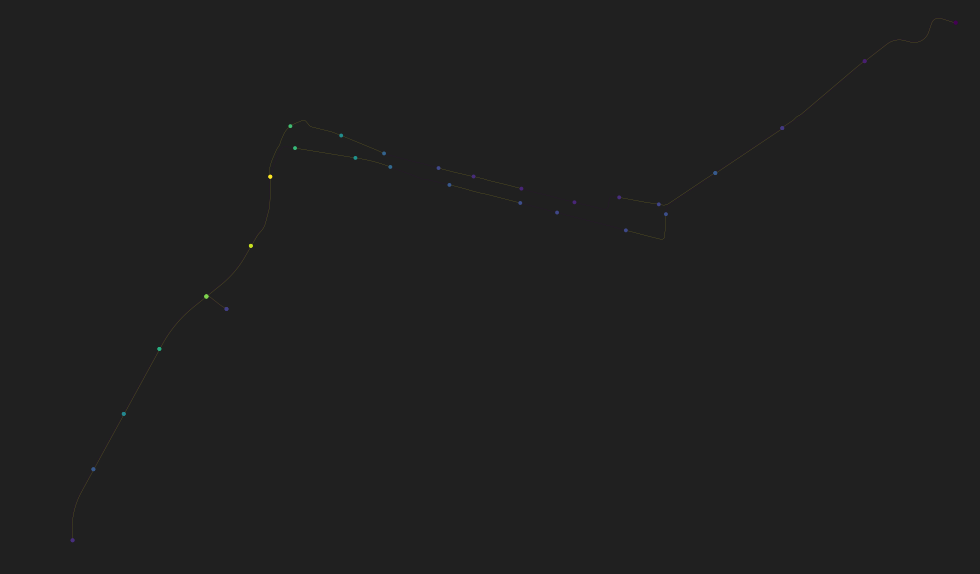

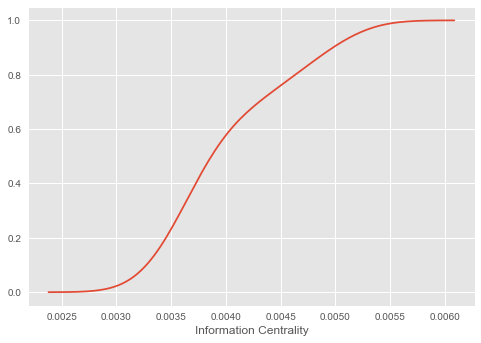

In [225]:
G = ms.network_stats(tram_network, 1)
ox.save_graph_shapefile(G, folder = graphs_folder, filename = '{}/shapefile'.format('tram_stats'))

## Assign Socio Economic Data to Nodes

voronoi tesselation and weighted area overlay interpolation is used to determine population data at each intersection.

In [13]:
#join ICV dataframe to block geometry
blocksICV = blocksGPD.merge(icvIndexDf, left_on = 'DPA_MANZAN', right_on = 'id_man')

#only conserve valid geometries with values
blocksICV = blocksICV[blocksICV.is_valid]
blocksICV = blocksICV.dropna()
blocksICV.to_file('{}/blocksICV'.format(output_path))

Ring Self-intersection at or near point 720396.05939999968 9681490.2802000009


Generating voronoi tesselation...


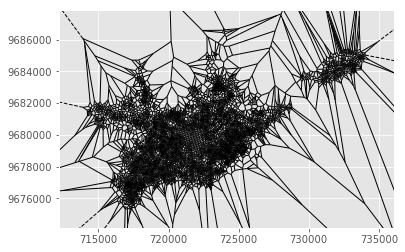

Generating geodataframe...


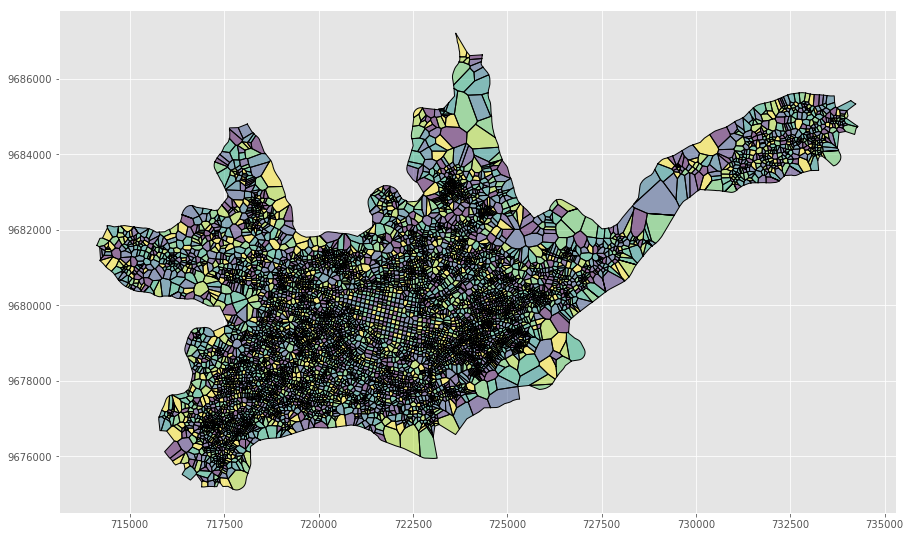

Calculating area overlay...
Calculating values for polygon...
Appending values to geometry...
done!


In [14]:
#map data to intersection
street_network = ms.blocks_to_nodes(street_network, 
                                   blocksICV, 
                                   area, 
                                   crs_utm)
#save to shapefile and graphml
ox.save_graph_shapefile(street_network, folder = graphs_folder, filename = '{}/shapefileICV'.format('street_network'))

## Create Multiplex

In [15]:
multiplex = ms.create_multiplex(street_network, [bus_network, tram_network], [15,10])

In [16]:
ox.save_graph_shapefile(multiplex, folder = graphs_folder, filename = '{}/shapefile'.format('multiplex'))
ox.save_graphml(multiplex, folder = graphs_folder, filename = '{}/graph'.format('multiplex'))

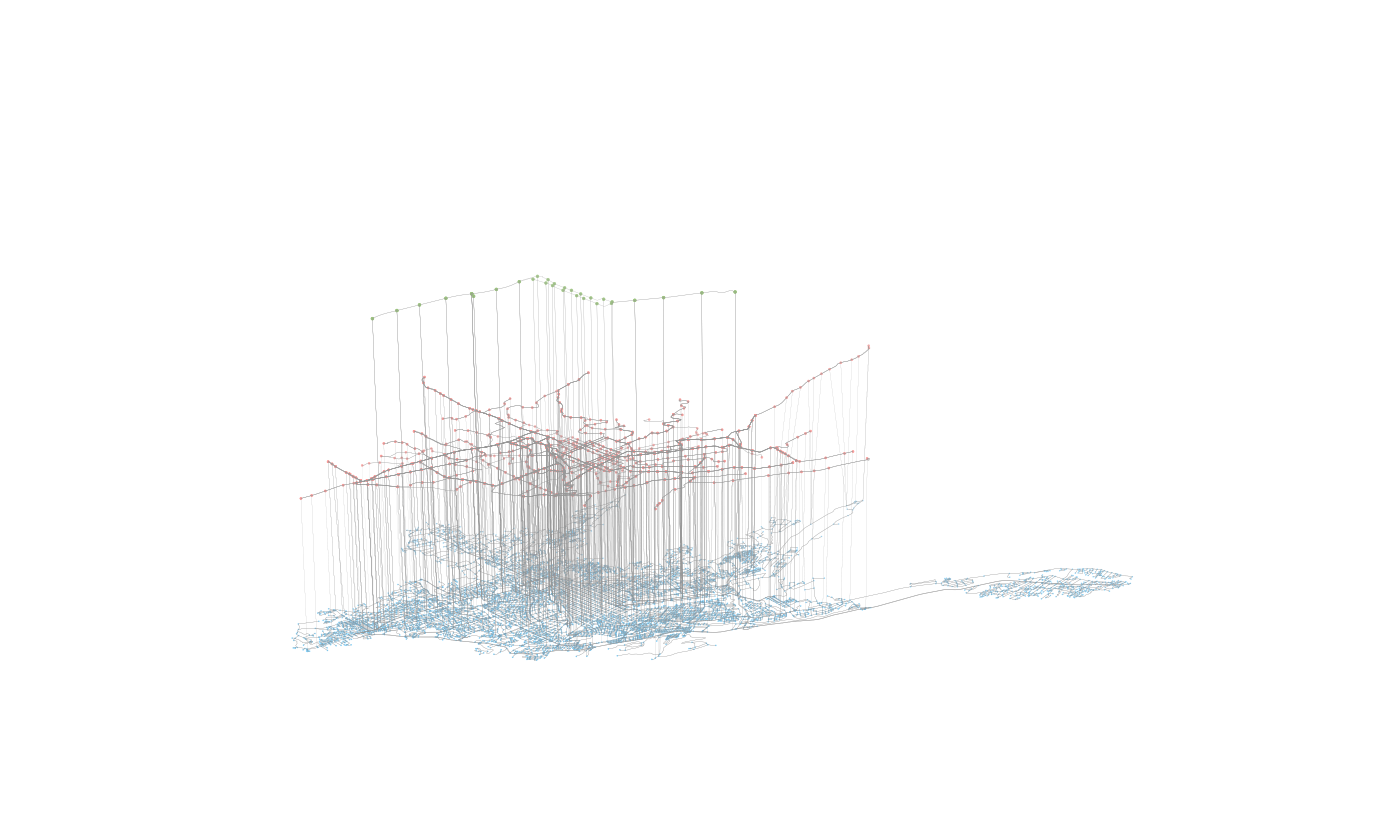

In [17]:
ms.plot_multiplex(multiplex, save = True)

## Get multiplex stats

In [ ]:
G = ms.network_stats(multiplex, 1)
ox.save_graph_shapefile(G, folder = graphs_folder, filename = '{}/shapefile'.format('multiplex_stats'))

calculating shortest path betweenness...


## Random Walk Segregation Index

In [74]:
G = tram_network.copy()

eb = nx.edge_betweenness_centrality(G, weight = 'weight')
nb = nx.betweenness_centrality(G, weight = 'weight')

keys= []
values= []
for u, v, key in G.edges(data=False, keys=True):
    value = eb[(u,v)]
    keys.append((u,v,key))
    values.append(value)
    
eb= dict(zip(keys, values))

nx.set_node_attributes(G, 'betweenness', nb)
nx.set_edge_attributes(G, 'betweenness', eb)

# G_undirected = G.to_undirected(reciprocal=False)
# erwb = nx.edge_current_flow_betweenness_centrality(G_undirected, weight = 'weight')
# nrwb = nx.current_flow_betweenness_centrality(G_undirected, weight = 'weight')

# G_line = nx.line_graph(G)
# erc = nx.global_reaching_centrality(G_line, weight='weight')
# nrc = nx.global_reaching_centrality(G, weight='weight')

# eic = nx.current_flow_closeness_centrality(G_line, weight = 'weight')
# nic = nx.current_flow_betweenness_centrality(G, weight = 'weight')


# measures = [[eb,nb, G, 'Betweenness Centrality'], 
#             [erwb,nrwb,G_undirected, 'Random Walk Betweenness'],
#             [erc,nrc,G, 'Reaching Centrality'],
#             [eic,nic,G, 'Information Centrality']
#            ]
# for measure in measures:
#     ev = []
#     for edge in measure[2].edges():
#         if edge in measure[0].keys():
#             ev.append(measure[0][edge])
#         else:
#             ev.append(-1)
#     enorm = colors.Normalize(vmin=min(ev), vmax=max(ev))
#     ecmap = cm.ScalarMappable(norm=enorm, cmap=cm.viridis)
#     ec= [ecmap.to_rgba(cl) for cl in ev]
    
#     nv = [measure[1][node] for node in measure[2]]
#     nnorm = colors.Normalize(vmin=min(nv), vmax=max(nv))
#     ncmap = cm.ScalarMappable(norm=nnorm, cmap=cm.viridis)    
#     nc= [ncmap.to_rgba(cl) for cl in nv]
    
#     fig, ax = ox.plot_graph(measure[2],
#                             fig_height = 10,
#                             node_size = 15,
#                             node_color = nc,
#                             node_zorder=2,
#                             edge_color=ec,
#                             edge_linewidth=0.1,
#                             edge_alpha=1,
#                             bgcolor = '#202020',
# #                             save = True,
#                             show = True,
#                             close = True,
# #                             filename = 'tram_stats_{}'.format('bc'), 
#                             dpi=600,
#                             equal_aspect=True,
#                            )
#     g = sns.distplot(nv, hist=False, kde_kws=dict(cumulative=True), 
#                  axlabel= 'Betweenness Centrality')




In [107]:
list(G.nodes(data=True))[3]

(3,
 {'betweenness': 0.14576074332171893,
  'geometry': <shapely.geometry.point.Point at 0x1ca206f8978>,
  'id': 3,
  'information centrality': 0.14422131334514818,
  'lgth': 8305.2801859192914,
  'network_type': 'tram',
  'ngeom': 1,
  'osmid': 3,
  'random walk betweenness': 0.14422131334514818,
  'way': 'Eje2_Direccion2',
  'x': 718662.0557936198,
  'y': 9678630.718798276,
  'z': 2})

In [177]:
G = tram_network.copy()
G_line = nx.line_graph(G)
G_undirected = G.to_undirected(reciprocal=False)
G_line_undirected = nx.line_graph(G_undirected)

print('calculating shortest path betweenness...')
eb = nx.betweenness_centrality(G_line, weight = 'weight')
nb = nx.betweenness_centrality(G, weight = 'weight')

print('calculating random walk betweenness...')

erwb = nx.current_flow_betweenness_centrality(G_line_undirected, weight = 'weight')
nrwb = nx.current_flow_betweenness_centrality(G_undirected, weight = 'weight')


print('calculating reaching centrality...')

print('calculating information centrality...')

eic = nx.current_flow_closeness_centrality(G_line_undirected, weight = 'weight')
nic = nx.current_flow_betweenness_centrality(G_undirected, weight = 'weight')

measures = [[eb,nb, G, 'Betweenness Centrality'], 
        [erwb,nrwb,G_undirected, 'Random Walk Betweenness'],
        [erc,nrc,G, 'Local Reaching Centrality'],
        [eic,nic,G, 'Information Centrality']
       ]

nx.set_node_attributes(G, 'betweenness', nb)
nx.set_edge_attributes(G, 'betweenness', eb)
nx.set_node_attributes(G, 'random walk betweenness', nrwb)
nx.set_edge_attributes(G, 'random walk betweenness', erwb)
nx.set_node_attributes(G, 'information centrality', nic)
nx.set_edge_attributes(G, 'information centrality', eic)

calculating shortest path betweenness...
calculating random walk betweenness...
calculating reaching centrality...
calculating information centrality...


KeyError: 2

In [165]:
values =erwb
len(values)

56

In [209]:
G = tram_network.copy()
G_undirected = G.to_undirected(reciprocal=False)
eic = nx.current_flow_closeness_centrality(G_line_undirected, weight = 'weight')

In [212]:
for u,v,k in G.edges(keys = True):
    if (u,v,k) in eic.keys():
        print(eic[(u,v,k)])
    elif (v,u,k) in eic.keys():
        print(eic[(v,u,k)])
    else:
        print('none')

0.004601932274640244
0.004986356101631345
0.0052365152758813375
0.005488738821224092
0.00569367919295258
0.005968779238060014
0.006161428488756555
0.006546680996215465
0.0065751774177768
0.006575177417776803
0.0066889620758872285
0.00674876018882249
0.006665184387568703
0.004301330735829192
0.005079098208241045
0.004410441612919716
0.004430074650592119
0.004069477837389521
0.003930871734163677
0.0037878448690894626
0.0035621437102115175
0.005636481808884453
0.0043124813580731084
0.004182994920450218
0.006487417349758945
0.006749599200360199
0.00675523414994994
0.004455918484876616
0.004704694035421735
0.004275795359084657
0.0042238580596729676
0.004215617214573682
0.00613916931159446
0.00548395865592614
0.0065751774177768
0.006416425006465248
0.006575394461236389
0.00548395865592614
0.00613916931159446
0.006575177417776803
0.006416425006465248
0.006575394461236387
0.00498636017185036
0.004601932274640244
0.005488753616340954
0.0052365152758813375
0.005968843391393676
0.0056936791929525

In [192]:
for u,v,k in G.edges(keys=True):
    print (u,v,k)

0 24 0
1 0 18
1 25 0
2 1 17
2 26 0
3 2 16
3 27 0
4 3 15
4 21 0
4 23 0
4 28 0
5 4 14
5 29 0
6 15 7
7 11 10
8 17 3
8 33 0
9 12 1
9 34 0
10 9 0
10 35 0
11 13 11
12 8 2
12 36 0
13 14 12
14 5 13
14 38 0
15 16 8
16 7 9
17 19 4
18 6 6
19 18 5
20 21 19
20 22 0
21 4 0
21 23 0
21 28 0
22 20 0
23 22 20
23 4 0
23 21 0
23 28 0
24 25 21
24 0 0
25 26 22
25 1 0
26 27 23
26 2 0
27 28 24
27 3 0
28 29 25
28 4 0
28 21 0
28 23 0
29 38 26
29 5 0
30 40 34
31 32 28
32 39 29
33 36 36
33 8 0
34 35 38
34 9 0
35 10 0
36 34 37
36 12 0
37 42 31
38 31 27
38 14 0
39 37 30
40 33 35
41 30 33
42 41 32
